In [2]:
# Import Modules
import math
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
import matplotlib.pyplot as plt
from warnings import catch_warnings
from warnings import simplefilter
import scipy.stats as stats
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from IPython.display import display
from scipy.optimize import minimize

## Batch Surrogate Model

In [3]:
# Data Gathering
#data_path = "C:/Users/USER/Documents/workspace/BMED/DB_bench_BMED_for_LA.xlsx"
data_path = "C:/Users/bsjun/Documents/workspace/BMED/DB_bench_BMED_for_LA.xlsx"
raw_Data= pd.read_excel(data_path,sheet_name="revised2")
raw_Data['C_B_LA'] = raw_Data['C_B_LA'].apply(lambda x:0 if x<0 else x)
display(raw_Data[:5])

,T_operation,V_operation,E_operation,t_operation,C_i,C_F_LA,C_A_LA,C_B_LA,C_F_K,C_A_K,C_B_K,V_F,V_A,V_B,CE,SEC,J_LA,Date,V-C
0,35,35,0.5,2.000000,3.247751,2.666598,0.272588,0.000000,2.179980,0.017253,0.686864,1.08,0.98,1.90,15.522230,6.563329,223.608106,230719,32.605990
1,35,35,0.5,2.933333,3.247751,2.470914,0.577139,0.010599,1.660887,0.027207,1.179806,1.03,1.00,1.93,19.058529,5.408487,543.993190,230719,33.106224
2,35,35,0.5,3.933333,3.247751,2.193242,1.063021,0.023075,1.109295,0.041413,1.734744,0.78,1.15,2.00,26.182700,3.958080,1056.942907,230719,33.869779
3,35,35,0.5,4.933333,3.247751,1.570518,1.593019,0.039529,0.649633,0.034028,2.124536,0.58,1.28,2.10,32.334484,3.211235,1337.426543,230719,35.022501
4,35,35,0.5,5.933333,3.247751,0.258292,2.081178,0.055639,0.096276,0.030335,2.372350,0.28,1.40,2.20,37.264021,2.788854,1432.411229,230719,36.822886


### BMED Mass Balance Model


##### Data Treatment

In [4]:
# Delclarate the dataframe
df_MB_columns = ['T_operation','V_operation','E_operation','t_operation','C_i','C_F_LA','C_A_LA','C_B_LA','V_F','V_A','V_B']
df_MB = raw_Data[df_MB_columns]
df_MB2 = df_MB.copy()
df_MB2['dCF'], df_MB2['dCA'], df_MB2['dCB'] = df_MB['C_i'] - df_MB['C_F_LA'], df_MB['C_A_LA'], df_MB['C_B_LA']
df_MB2['dVF'], df_MB2['dVA'], df_MB2['dVB'] = df_MB['V_F'] - 1, df_MB['V_A'] - 1, df_MB['V_B'] - 2

# Data Set declaration
X = df_MB2[['T_operation','V_operation','E_operation','t_operation','C_i']].values
Y = df_MB2[['dCF','dCA']].values

# Data split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

#### ANN Model

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
# Tensor
X_ts = torch.tensor(X, dtype=torch.float32)
Y_ts = torch.tensor(Y, dtype=torch.float32)

# # Data split
# Xts_train, Xts_test, Yts_train, Yts_test = train_test_split(X_ts, Y_ts, test_size = 0.2, random_state=42)
# kfold = KFold(n_splits=5, shuffle=True, random_state= 42)

# model_ANN = list(range(5))
# loss_ANN = list(range(5))
# iter = 0
# for train_index, val_index in kfold.split(Xts_train):
    
#     X_t, X_v = X_ts[train_index], X_ts[val_index]
#     Y_t, Y_v = Y_ts[train_index], Y_ts[val_index]

#     model = nn.Sequential(
#         nn.Linear(5,10),
#         nn.ReLU(),
#         nn.Linear(10,12),
#         nn.ReLU(),
#         nn.Linear(12,6),
#         nn.ReLU(),
#         nn.Linear(6,3)
#     )

#     criterion = nn.MSELoss()
#     optimizer = optim.SGD(model.parameters(), lr=0.01)

#     num_epochs = 10000
    
#     for epoch in range(num_epochs):
#         for i in range(len(X_t)):
#             inputs = X_t[i]
#             targets = Y_t[i]

#             outputs = model(inputs)

#             loss = criterion(outputs, targets)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         if (epoch + 1) % 100 == 0:
#             print(f'Fold [{iter+1}/{5}], Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.8f}')
#     model_ANN[iter] = model
#     loss_ANN[iter] = loss    
        
#     iter += 1

model = nn.Sequential(
        nn.Linear(5,10),
        nn.ReLU(),
        nn.Linear(10,16),
        nn.ReLU(),
        nn.Linear(16,8),
        nn.ReLU(),
        nn.Linear(8,4),
        nn.ReLU(),
        nn.Linear(4,2)
    )

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

num_epochs = 1000000

for epoch in range(num_epochs):
    for i in range(len(X_ts)):
        inputs = X_ts
        targets = Y_ts

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.8f}')



Epoch [100/1000000], Loss: 0.30210727
Epoch [200/1000000], Loss: 0.08566867
Epoch [300/1000000], Loss: 0.05552792
Epoch [400/1000000], Loss: 0.04293778
Epoch [500/1000000], Loss: 0.02677530
Epoch [600/1000000], Loss: 0.02093657
Epoch [700/1000000], Loss: 0.01825727
Epoch [800/1000000], Loss: 0.01667086
Epoch [900/1000000], Loss: 0.01570627
Epoch [1000/1000000], Loss: 0.01510484
Epoch [1100/1000000], Loss: 0.01469574
Epoch [1200/1000000], Loss: 0.01438410
Epoch [1300/1000000], Loss: 0.01415431
Epoch [1400/1000000], Loss: 0.01396523
Epoch [1500/1000000], Loss: 0.01379627
Epoch [1600/1000000], Loss: 0.01360686
Epoch [1700/1000000], Loss: 0.01347383
Epoch [1800/1000000], Loss: 0.01334904
Epoch [1900/1000000], Loss: 0.01324007
Epoch [2000/1000000], Loss: 0.01313880
Epoch [2100/1000000], Loss: 0.01304487
Epoch [2200/1000000], Loss: 0.01295554
Epoch [2300/1000000], Loss: 0.01287090
Epoch [2400/1000000], Loss: 0.01279600
Epoch [2500/1000000], Loss: 0.01271715
Epoch [2600/1000000], Loss: 0.0126

KeyboardInterrupt: 

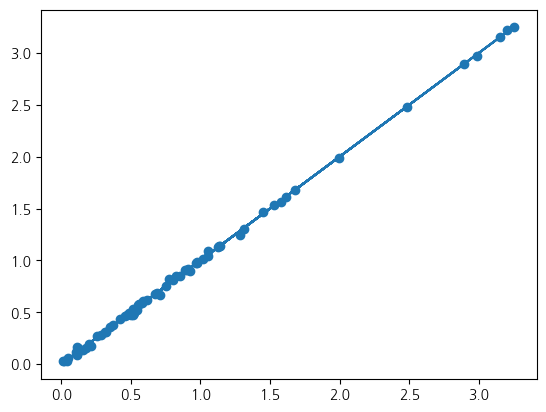

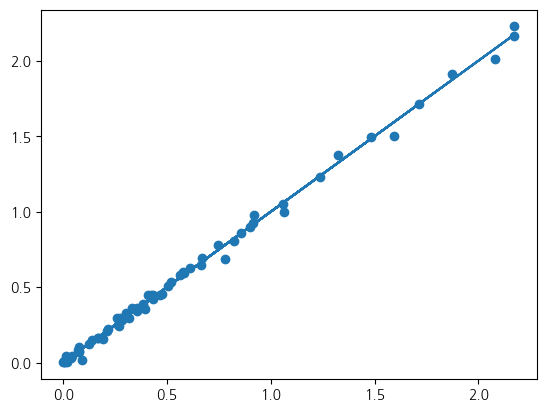

In [ ]:
# torch detachment
def tor_dt(x):
    return x.detach().numpy()

# loss_ANN_tr = np.asarray(list(map(tor_dt,loss_ANN)))
# print(loss_ANN_tr)
# model_ANN_f = model_ANN[np.argmin(loss_ANN_tr)]

Y_pred = model(X_ts)
Y_tensor_t = Y_ts.detach().numpy()
Y_pred_t = Y_pred.detach().numpy()

for i in range(2):
    plt.plot([j[i] for j in Y_tensor_t],[j[i] for j in Y_tensor_t])
    plt.scatter([j[i] for j in Y_tensor_t],[j[i] for j in Y_pred_t])
    plt.show()

torch.save(model.state_dict(), "model_total data_v0.pt")